Success: True
Message: Optimization terminated successfully.
Number of iterations: 193
Objective function (sum of squared errors): 9.124892149291172


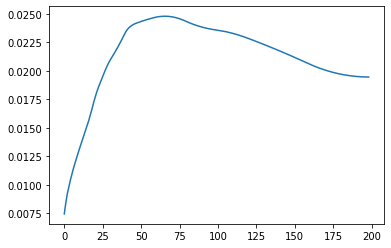

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as pl

# sum of squared errors of all decision variables
# args: 0 = array of given initial rates, 1 = scaling factor
def ObjectiveFunction(x, args):
    # concatenate given initial rates and given 'guesses' for forward rates
    x = np.concatenate([args[0], x])
    return np.sum(np.power(np.diff(x), 2) * args[1])

# x = array of Libor forward rates
# args: 0 = swap rate, 1 = years to maturity, 2 = floating leg payments per year, 
# 3 = notional, 4 = array of given initial rates
def VanillaSwapPV(x, args):
    # PV (fixed payer swap) = -swapRate * Q(T) + (1 - DF(T))
    # where Q(T) is sumproduct of fixed leg discount factors and corresponding time accrual factors
    # assumption : fixed leg is always paid annually
    # since fixed leg is paid annually and maturity is always integer, 
    # time accrual factor will always be exactly 1.0
    
    # concatenate given initial rates and given 'guesses' for forward rates
    x = np.concatenate([args[4], x])
    DF = 0.0
    Q  = 0.0
    floatingLegTenor = 1 / args[2]
    nextFixedLegCouponDate = 1
    currentTimePoint = 0.0
    nCashFlows = int(args[1] * args[2])
    
    for i in range(nCashFlows):
        currentTimePoint += floatingLegTenor
        # first rate is always spot rate: calculate first spot discount factor
        if (i == 0):
            DF = 1 / (1 + x[i] * floatingLegTenor)
        # other rates are always forward rates
        if (i > 0):
            # solve current spot discount factor using previous spot discount factor
            # and current forward discount factor: DF(0,T) = DF(0,t) * DF(t,T), where (0 < t < T)
            DF *= (1 / (1 + x[i] * floatingLegTenor))
            if ((currentTimePoint - nextFixedLegCouponDate) == 0):
                Q += DF
                nextFixedLegCouponDate += 1
                
    return (-args[0] * Q + (1.0 - DF)) * args[3]

# array of given initial rates (the first given rate has to be spot cash rate)
# here, we give only one: 3M spot Libor fixing rate ('cash-to-first-future')
initialRates = np.array([0.006276])
scalingFactor = 1000000.0

# vanilla swap pricing functions as constraints
# args: swapRate, yearsToMaturity, floatingLegPaymentFrequency, notional, array of given initial rates
swaps = ({'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.0078775, 1, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.009295, 2, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.0103975, 3, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.01136, 4, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.012268, 5, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.013183, 6, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.01404, 7, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.014829, 8, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.01554, 9, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.016197, 10, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.016815, 11, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.017367, 12, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.018645, 15, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.01996, 20, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.020615, 25, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.02097, 30, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.021155, 40, 4, scalingFactor, initialRates]]},
        {'type': 'eq', 'fun': VanillaSwapPV, 'args': [[0.021017, 50, 4, scalingFactor, initialRates]]})

# initial guesses for Libor forward rates up to 50 years
# number of rates: 50 * 4 - 1 (years to maturity * floating leg payments per year - first given cash spot rate)
initialGuesses = np.full(199, 0.006)
model = opt.minimize(ObjectiveFunction, initialGuesses, args = ([initialRates, scalingFactor]), method = 'SLSQP', options = {'maxiter': 500}, constraints = swaps)

# print selected model results
print('Success: ' + str(model.success))
print('Message: ' + str(model.message))
print('Number of iterations: ' + str(model.nit))
print('Objective function (sum of squared errors): ' + str(model.fun))
#print('Changing variables (Libor forward rates): ' + str(model.x * 100))
pl.plot(model.x)
pl.show()